In [1]:

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 120
SEED = 2


In [4]:
!pip install pytket-qiskit
!pip install lambeq==0.3.3 # MAKE SURE YOU INSTALL THIS VERSION TO MAKE SURE WE ALL ON THE SAME PAGE :)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [5]:

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [6]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1


In [7]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)


Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


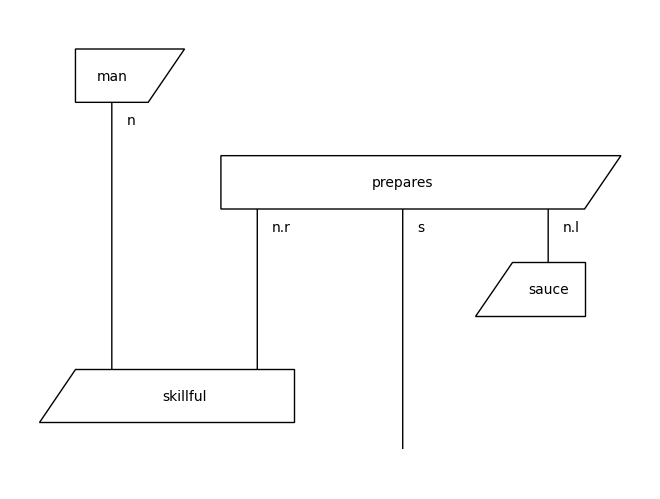

In [8]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

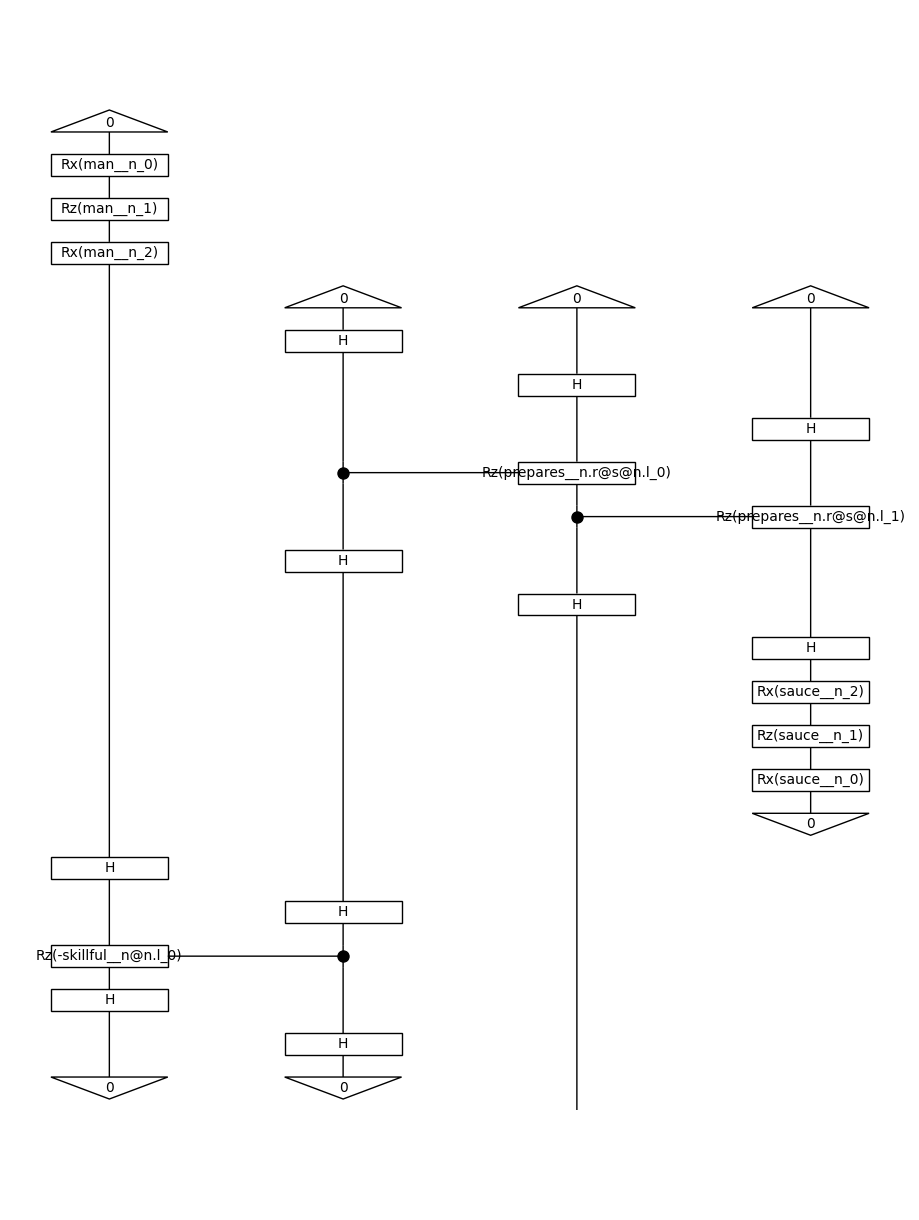

In [9]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

In [10]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
# model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

# Are you connected to some GPU-enabled runtime? In that case, use JIT models instead!!

from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=False)


In [11]:

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss(use_jax = False)

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [12]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [13]:
len(dev_circuits)

30

In [14]:

from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=True)

In [15]:
trainer.fit(train_dataset, val_dataset, log_interval=4)


Epoch 4:    train/loss: 0.9911   valid/loss: 0.7465   train/acc: 0.5429   valid/acc: 0.6000
Epoch 8:    train/loss: 0.8291   valid/loss: 0.8218   train/acc: 0.5143   valid/acc: 0.5667
Epoch 12:   train/loss: 0.5490   valid/loss: 0.9491   train/acc: 0.6714   valid/acc: 0.5667
Epoch 16:   train/loss: 0.8933   valid/loss: 1.2000   train/acc: 0.7286   valid/acc: 0.5000
Epoch 20:   train/loss: 0.7207   valid/loss: 1.0433   train/acc: 0.7143   valid/acc: 0.4667
Epoch 24:   train/loss: 0.5291   valid/loss: 1.1119   train/acc: 0.7000   valid/acc: 0.4667
Epoch 28:   train/loss: 0.5179   valid/loss: 0.8767   train/acc: 0.6857   valid/acc: 0.4667
Epoch 32:   train/loss: 0.5198   valid/loss: 0.6705   train/acc: 0.7571   valid/acc: 0.5333
Epoch 36:   train/loss: 0.4054   valid/loss: 0.6787   train/acc: 0.7571   valid/acc: 0.5333
Epoch 40:   train/loss: 0.3275   valid/loss: 0.6778   train/acc: 0.7857   valid/acc: 0.5333
Epoch 44:   train/loss: 0.5064   valid/loss: 0.6425   train/acc: 0.7571   valid/

Test accuracy: 0.7333333333333333


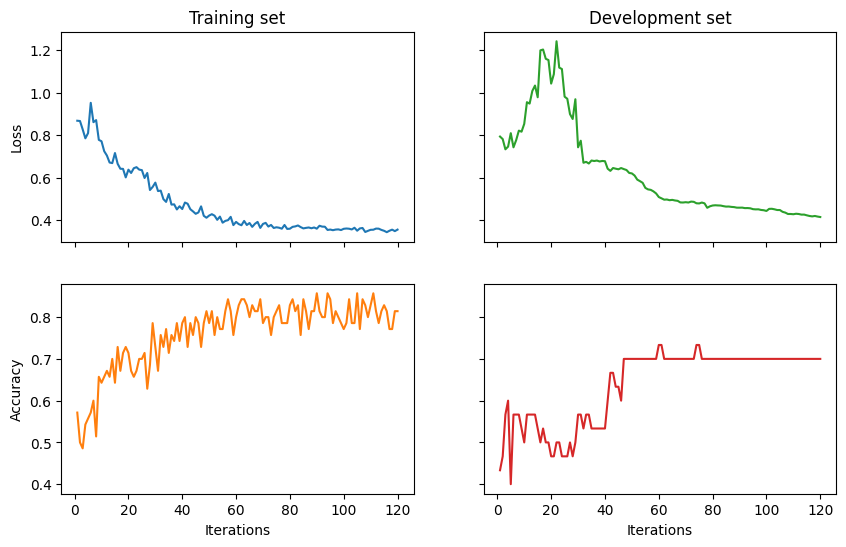

In [16]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs +1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)

In [ ]:
test_acc /= acc(model(test_circuits), np.array(test_labels))

In [ ]:
print(test_acc)

1.0


In [ ]:
model(test_circuits[:5])



array([[0.52911908, 0.47088092],
       [0.43530207, 0.56469793],
       [0.19052919, 0.80947081],
       [0.66089759, 0.33910241],
       [0.88856585, 0.11143415]])

In [ ]:
print(test_labels)

[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]


In [ ]:
model([test_circuits[2]])

array([[0.19052919, 0.80947081]])

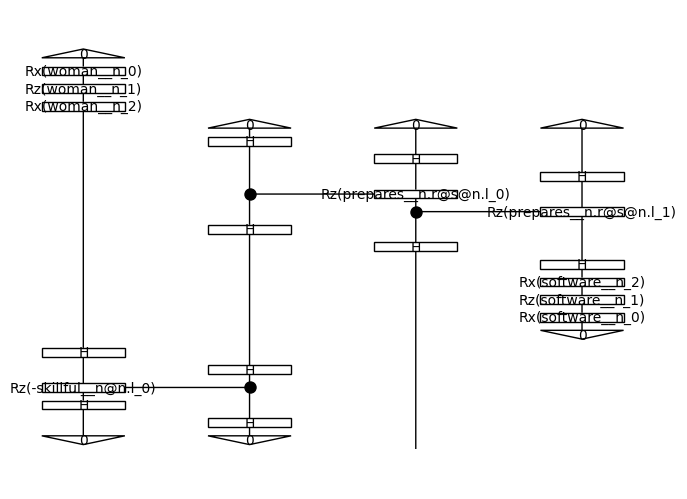

In [ ]:
test_circuits[2].draw()

In [ ]:
model.weights
print(diagram)
import tensornetwork as tn
lamdaified = model._get_lambda(circuit)

print(lamdaified)
print(tn.contractors)

lamdaified(model.weights)

NameError: ignored

In [ ]:

from collections.abc import Callable, Iterable
import pickle
from typing import Any, TYPE_CHECKING

import discopy
from discopy.tensor import Diagram
import numpy
from numpy.typing import ArrayLike
from sympy import lambdify


def _fast_subs(self,
                   diagrams: list[Diagram],
                   weights: Iterable[ArrayLike]) -> list[Diagram]:
        """Substitute weights into a list of parameterised circuit."""
        parameters = {k: v for k, v in zip(self.symbols, weights)}
        diagrams = pickle.loads(pickle.dumps(diagrams))  # does fast deepcopy
        for diagram in diagrams:
            for b in diagram.boxes:
                if b.free_symbols:
                    while hasattr(b, 'controlled'):
                        b = b.controlled
                    syms, values = [], []
                    for sym in b.free_symbols:
                        syms.append(sym)
                        try:
                            values.append(parameters[sym])
                        except KeyError as e:
                            raise KeyError(
                                f'Unknown symbol: {repr(sym)}'
                            ) from e
                    b.data = lambdify(syms, b.data)(*values)
                    b.drawing_name = b.name
                    del b.free_symbols
        return diagrams

In [ ]:
circuit_2 = model._fast_subs([test_circuits[2]], model.weights)[0]
from pytket.circuit.display import render_circuit_jupyter
tket_circuit = circuit_2.to_tk()
render_circuit_jupyter(tket_circuit)

In [ ]:
sentence = "skillful man kailashes today"

diagram = parser.sentence2diagram(sentence)

diagram = remove_cups(diagram)
diagram.draw()
circuit = ansatz(diagram)

model([circuit])

NameError: ignored

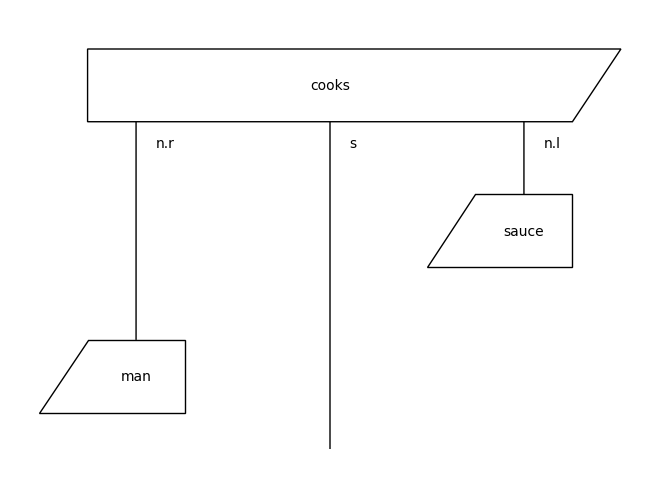

Array([[0.89528275, 0.10471724]], dtype=float32)

In [ ]:
bsentence = "he cooks food"

diagram = parser.sentence2diagram(sentence)

diagram = remove_cups(diagram)
diagram.draw()


circuit = ansatz(diagram)

model([circuit])


In [ ]:
print(model)

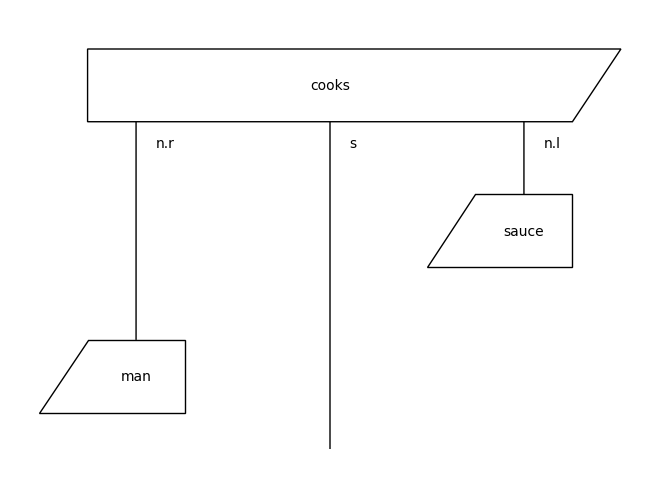

Array([[0.89528275, 0.10471724]], dtype=float32)

In [ ]:
bsentence = "man cooks sauce"

diagram = parser.sentence2diagram(sentence)

diagram = remove_cups(diagram)
diagram.draw()


man_circuit = ansatz(diagram)

model([circuit])

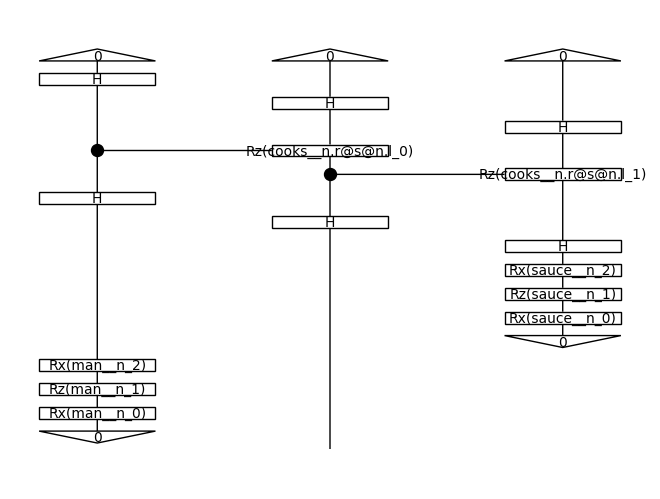

In [ ]:
circuit.draw()

In [ ]:
circuit_3 = model._fast_subs([man_circuit], model.weights)[0]
from pytket.circuit.display import render_circuit_jupyter
tket3_circuit = circuit_3.to_tk()
render_circuit_jupyter(tket3_circuit)

In [ ]:
model.symbols

[application__n_0,
 application__n_1,
 application__n_2,
 bakes__n.r@s@n.l_0,
 bakes__n.r@s@n.l_1,
 cooks__n.r@s@n.l_0,
 cooks__n.r@s@n.l_1,
 debugs__n.r@s@n.l_0,
 debugs__n.r@s@n.l_1,
 debugs__n@n.l_0,
 dinner__n_0,
 dinner__n_1,
 dinner__n_2,
 man__n@n.l_0,
 man__n_0,
 man__n_1,
 man__n_2,
 meal__n_0,
 meal__n_1,
 meal__n_2,
 person__n@n.l_0,
 person__n_0,
 person__n_1,
 person__n_2,
 prepares__n.r@s@n.l_0,
 prepares__n.r@s@n.l_1,
 program__n_0,
 program__n_1,
 program__n_2,
 runs__n.r@s@n.l_0,
 runs__n.r@s@n.l_1,
 sauce__n_0,
 sauce__n_1,
 sauce__n_2,
 skillful__n@n.l_0,
 software__n_0,
 software__n_1,
 software__n_2,
 tasty__n@n.l_0,
 useful__n@n.l_0,
 woman__n@n.l_0,
 woman__n_0,
 woman__n_1,
 woman__n_2]

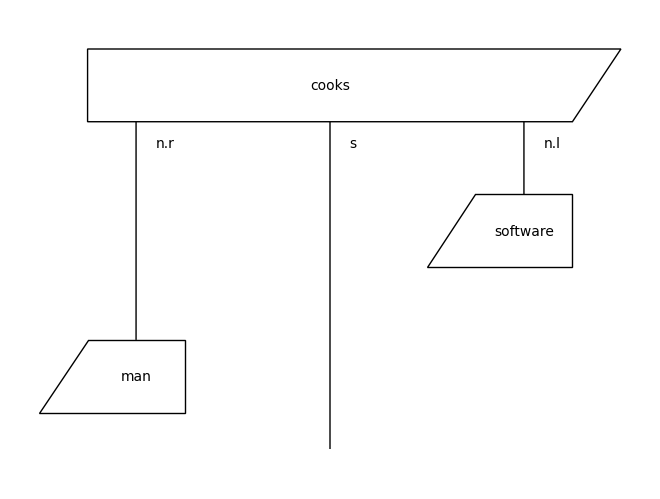

Array([[0.88499844, 0.11500158]], dtype=float32)

In [ ]:
csentence = "man cooks software"

cdiagram = parser.sentence2diagram(csentence)

cdiagram = remove_cups(cdiagram)
cdiagram.draw()


man2_circuit = ansatz(cdiagram)

model([man2_circuit])

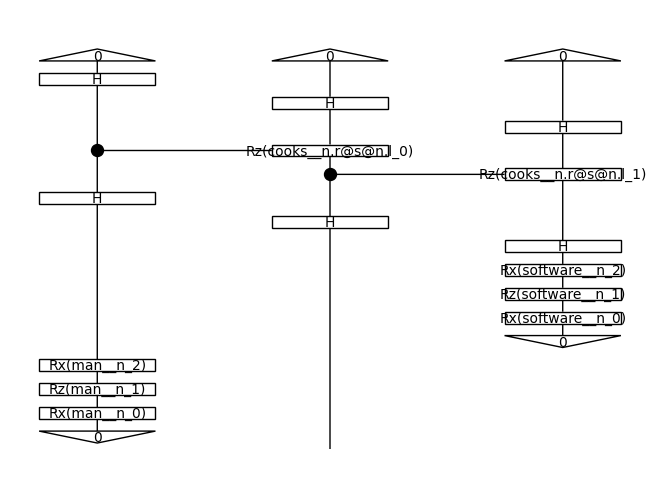

In [ ]:
man2_circuit.draw()

In [ ]:
circuit_4 = model._fast_subs([man2_circuit], model.weights)[0]
from pytket.circuit.display import render_circuit_jupyter
tket4_circuit = circuit_4.to_tk()
render_circuit_jupyter(tket4_circuit)

In [29]:
!pip install frozenmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for frozenmap: filename=frozenmap-0.6-cp310-cp310-linux_x86_64.whl size=478334 sha256=fa7c4e42889fcb61e8dd8ddc93a74f023b5b5370fe70fd8bc8681c75d98827d2
  Stored in directory: /root/.cache/pip/wheels/06/91/83/f5ca5158cb2e781ac2322938f42f2feb85b293e845f17864ee
Successfully built frozenmap


In [43]:
# Sentence generation

from nltk import CFG
from nltk.parse.generate import generate


sentence_map = {}
def _create_sentence_search_space():
    MC_GRAMMAR = """
      S -> NP VP
      NP -> N
      VP -> V NP
      NP -> A N
      A -> 'skillful' | 'tasty' | 'useful'
      N -> 'application' | 'dinner' | 'man' | 'meal' | 'person' | 'program' | 'sauce' | 'software' | 'woman'
      V -> 'bakes' | 'cooks' | 'debugs' | 'prepares' | 'runs'
      """

    VOCAB = ['debugs', 'dinner', 'person', 'useful', 'runs', 'program', 'bakes', 'cooks', 'skillful', 'woman', 'prepares', 'application', 'man', 'software', 'sauce', 'meal', 'tasty']

    subjects = ["man", "woman", "person"]
    objects = ["sauce", "meal", "application", "software", "dinner", "program"]

    GRAMMAR = CFG.fromstring(MC_GRAMMAR)
    SENTENCES = list(generate(GRAMMAR))

    def filter_sentence(sentence):
        # Make sure no word appears more than once:
        if not len(set(sentence)) == len(sentence):
            return False

        # Make sure subject appears before object:
        try:
            subject_position = next(i for i,v in enumerate(sentence) if v in subjects)
            object_position = next(i for i,v in enumerate(sentence) if v in objects)
        except:
            return False
        return subject_position < object_position

    SENTENCES = list(filter(filter_sentence, SENTENCES))
    return SENTENCES


def create_adjacency_list(sentences):
    adjacency_list = {tuple(sentence): [] for sentence in sentences}

    for i, sentence1 in enumerate(sentences):
        for j, sentence2 in enumerate(sentences):
            if i != j and is_array_edit_distance_equal_to_1(sentence1, sentence2):
                adjacency_list[tuple(sentence1)].append(sentence2)

    return adjacency_list

def sentence_diff(s1, s2):
  return is_array_edit_distance_equal_to_1(s1, s2)


def array_edit_distance(arr1, arr2):
    m, n = len(arr1), len(arr2)

    # Create a matrix to store the dynamic programming results
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the matrix with the distances for empty arrays
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Fill in the matrix using the Wagner-Fisher algorithm
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if arr1[i - 1] == arr2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,      # Deletion
                           dp[i][j - 1] + 1,      # Insertion
                           dp[i - 1][j - 1] + cost)  # Substitution

    # Return the final array-level edit distance
    return dp[m][n]

def is_array_edit_distance_equal_to_1(arr1, arr2):
    # Check if the array-level edit distance is equal to 1
    return array_edit_distance(arr1, arr2) == 1


def _measure_quantum_circuit_for_sentence(sentence):
    diagram = parser.sentences2diagrams([sentence])

    circ = [ansatz(d) for d in diagram]

    return model.get_diagram_output(circ)[0]

In [36]:
import collections

# got this from some random stack overflow post but idt i actually need it
class FrozenDict(collections.abc.Mapping):
    """Don't forget the docstrings!!"""

    def __init__(self, *args, **kwargs):
        self._d = dict(*args, **kwargs)
        self._hash = None

    def __iter__(self):
        return iter(self._d)

    def __len__(self):
        return len(self._d)

    def __getitem__(self, key):
        return self._d[key]

    def __hash__(self):
        # It would have been simpler and maybe more obvious to
        # use hash(tuple(sorted(self._d.iteritems()))) from this discussion
        # so far, but this solution is O(n). I don't know what kind of
        # n we are going to run into, but sometimes it's hard to resist the
        # urge to optimize when it will gain improved algorithmic performance.
        if self._hash is None:
            hash_ = 0
            for pair in self.items():
                hash_ ^= hash(pair)
            self._hash = hash_
        return self._hash

In [24]:
|sentence1 = ['tasty', 'woman', 'runs', 'skillful', 'software']
sentence2 = ['boop', 'hi', 'runs', 'skillful', 'software']


print(is_array_edit_distance_equal_to_1(sentence1, sentence2))

False


In [44]:
import random
SENTENCES = _create_sentence_search_space()
sentence_map = create_adjacency_list(SENTENCES)

In [45]:
print(sentence_map)

{('man', 'bakes', 'application'): [['man', 'bakes', 'dinner'], ['man', 'bakes', 'meal'], ['man', 'bakes', 'program'], ['man', 'bakes', 'sauce'], ['man', 'bakes', 'software'], ['man', 'bakes', 'skillful', 'application'], ['man', 'bakes', 'tasty', 'application'], ['man', 'bakes', 'useful', 'application'], ['man', 'cooks', 'application'], ['man', 'debugs', 'application'], ['man', 'prepares', 'application'], ['man', 'runs', 'application'], ['person', 'bakes', 'application'], ['woman', 'bakes', 'application'], ['skillful', 'man', 'bakes', 'application'], ['tasty', 'man', 'bakes', 'application'], ['useful', 'man', 'bakes', 'application']], ('man', 'bakes', 'dinner'): [['man', 'bakes', 'application'], ['man', 'bakes', 'meal'], ['man', 'bakes', 'program'], ['man', 'bakes', 'sauce'], ['man', 'bakes', 'software'], ['man', 'bakes', 'skillful', 'dinner'], ['man', 'bakes', 'tasty', 'dinner'], ['man', 'bakes', 'useful', 'dinner'], ['man', 'cooks', 'dinner'], ['man', 'debugs', 'dinner'], ['man', 'pre

In [59]:
import random

# Food or IT
# keeps randomly generating sentences & takes sentence if classifier confidence > threshold (0.9)

# generate_sentence(topic, T)
# 1. Randomly generate sentence
# 2. Check confidence threshold (is p > 0.9)
# 3. if it's not, replace one of the words in the sentence.
# 4. check confidence threshold (is new p > old p), and if so, we want to commit that change
# 5. f(T) > threshold: even if confidence threshold is NOT increased by the change, we still commit the change
# 6. run for many iterations


# Simulated annealing, metropolis-hastings
def randomly_generate_sentence_with_topic(topic, T):
    i = 0
    current_sentence = random.choice(SENTENCES)
    print(current_sentence)
    current_prediction = _measure_quantum_circuit_for_sentence(" ".join(current_sentence))

    while i < 100:
        i += 1
        print(i)
        new_sentence = random.choice(sentence_map[tuple(current_sentence)])
        print(new_sentence)
        new_prediction = _measure_quantum_circuit_for_sentence(" ".join(new_sentence))
        # At each timestep, choose one word to replace


        print(new_prediction)
        relevant_index = 1 if topic == "IT" else 0
        if current_prediction[relevant_index] > 0.9:
          return i, current_prediction
          break
        if new_prediction[relevant_index] > 0.9:
          return i, new_sentence
          break
        acceptance_P = np.exp(-(new_prediction[relevant_index] - current_prediction[relevant_index])/T)
        random_dude = random.random()

        if new_prediction[relevant_index] > current_prediction[relevant_index] and random_dude < acceptance_P:
          current_sentence = new_sentence
          current_prediction = new_prediction

    return 100, "Max iterations reached"

In [60]:
randomly_generate_sentence_with_topic("IT", 0)

['tasty', 'woman', 'runs', 'useful', 'application']


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


1
['skillful', 'woman', 'runs', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.35370214 0.64629786]
2
['tasty', 'woman', 'runs', 'useful', 'dinner']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.67332943 0.32667057]
3
['tasty', 'woman', 'runs', 'useful', 'dinner']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.67332943 0.32667057]
4
['tasty', 'woman', 'prepares', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.74561219 0.25438781]
5
['tasty', 'woman', 'runs', 'useful', 'program']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.72186347 0.27813653]
6
['tasty', 'woman', 'cooks', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.90847866 0.09152134]
7
['tasty', 'woman', 'runs', 'skillful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.60907077 0.39092923]
8
['tasty', 'woman', 'runs', 'useful', 'dinner']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.67332943 0.32667057]
9
['tasty', 'woman', 'cooks', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.90847866 0.09152134]
10
['tasty', 'person', 'runs', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.90777242 0.09222758]
11
['tasty', 'woman', 'runs', 'useful', 'program']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.72186347 0.27813653]
12
['tasty', 'woman', 'runs', 'skillful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.60907077 0.39092923]
13
['tasty', 'woman', 'runs', 'useful', 'sauce']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.71721233 0.28278767]
14
['tasty', 'woman', 'prepares', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.74561219 0.25438781]
15
['tasty', 'woman', 'runs', 'skillful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.60907077 0.39092923]
16
['tasty', 'woman', 'prepares', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.74561219 0.25438781]
17
['tasty', 'woman', 'runs', 'useful', 'dinner']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.67332943 0.32667057]
18
['tasty', 'man', 'runs', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.78933651 0.21066349]
19
['skillful', 'woman', 'runs', 'useful', 'application']


Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.


[0.35370214 0.64629786]
20
['tasty', 'woman', 'debugs', 'useful', 'application']
[0.01377928 0.98622072]


Parsing tagged sentences.
Turning parse trees to diagrams.


(20, ['tasty', 'woman', 'debugs', 'useful', 'application'])